# Final Project: Hermite RBF Interpolation Digital Inpainting
# SCC0251 - Processamento de Imagens
---

### Nome: Guilherme Valderramos Montroni
### Nº USP: 13062539
---


It is not new that radial basis functions are used in interpolation practices on meshes and surfaces. A very recurrent task, which has obtained extremely satisfactory results, is the reconstruction of implicit functions that interpolate surfaces with a high degree of accuracy (Macedo et al [[1]](https://www.visgraf.impa.br/Data/RefBib/PS_PDF/cgf2010/macedo-HRBFImplicits-CGF.pdf),[[2]](https://www.researchgate.net/publication/221337481_Hermite_Interpolation_of_Implicit_Surfaces_with_Radial_Basis_Functions)).

<p align="center">
	<img align="center" width="360" height="300" src="https://user-images.githubusercontent.com/96217617/177058589-87b8f492-8b37-479f-ab88-d1f8e1d69023.png">
</p>

By interpreting the position of the pixels as a mesh and the values of the intensities being the known region under the mesh, we can calculate an interpolating function on the surface (S) that passes through each pixel in the image. Thus, our intention is to apply this practice to the digital painting process in order to reconstruct a degraded image.

<p align="center">
	<img align="center" width="220" height="200" src="https://user-images.githubusercontent.com/96217617/174624393-90260057-9741-45fa-a0a6-c553dd58bab6.png">

  <img align="center" width="340" height="220" src="https://user-images.githubusercontent.com/96217617/174624841-f00bdaea-7feb-4182-8558-a0bf8818815c.png">
</p>

The **Hermite RBF Interpolation Digital Inpainting** method takes as input a degraded image and a mask stating the region to be restored (by pattern we determine the black region as the retouch region).

In the step-by-step Hermite interpolation we need the existing pixel intensities (i.e. $x_i = \lambda_i f$) and the partial derivatives in the x and y direction (given by the gradient), being obtained in discrete form by finite differences.

$$
P_f(x) = \sum_{j=1}^N c_j \psi_j(||x||), \hspace{.5cm} x \in \mathbb{R}^S.
$$

$\psi_j$ is a radial basis function satisfying the interpolation condition $P_f$, where

$$
\lambda_i P_f = \lambda_i f \hspace{.5cm} i = 1, ..., N.
$$

With the intensity and its derivatives in hand, we can determine the Hermite RBF interpolating function by solving the linear system $Ac = P_f$, where $A$ is a matrix of the form:

<p align="center">
	<img align="center" width="650" height="280" src="https://user-images.githubusercontent.com/96217617/174632862-73b17d24-ab63-4c50-8307-63299ffbc8b2.png">

with $\xi_j$ the pixel degraded.  

Restoration happens when for each degraded pixel the *k* good pixels (cyan pixel) closest (k = 4 in image) to the target pixel (red pixel) are selected using a multi-quadratic radial basis function (green circle). The process repeats until all pixels in the image are restored as the figure (Fonte: [[3]](http://gibis.unifesp.br/sibgrapi16/eproceedings/wip/2.pdf)) below illustrates.

<p align="center">
	<img align="center" width="600" height="300" src="https://user-images.githubusercontent.com/96217617/174633060-24d9e6cf-25fe-4c8c-b2d3-8de54c4b9ddc.png">

#**Packages**

In [1]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
import numpy.matlib
from scipy.spatial import distance_matrix

#**Functions**

In [2]:
# NORMALIZE
def normalize(img, factor):
    img_min = np.min(img)                         # min of image
    img_max = np.max(img)                         # max of image
    img = (img - img_min)/(img_max-img_min)       # normalize of image between 0 and 1
    return (img*factor)

In [3]:
# RGB to Grayscale image
def rgb2gray(img):
    new_img = np.array(img, copy=True).astype(float)
    # computing conversion
    new_img = np.zeros((img.shape[0], img.shape[1]))
    new_img = img[:,:,0]*0.299 + img[:,:,1]*0.587 + img[:,:,2]*0.114  # Luminance conversion
    new_img = normalize(new_img, 255)

    return (new_img.astype(np.uint8))

In [4]:
# GRID for local method
def grid(img):
  # Creates the image grid to determine the position of each pixel

  row = img.shape[0] 
  col = img.shape[1]

  # Indices of each pixel
  idx = np.array([[[i, j] for j in range(col)] for i in range(row)])

  return (idx)

In [5]:
# GRID for global method
def grid1(mask):
  # Creates the image grid to determine the position of each pixel
  
  # shape image
  M,N = mask.shape                    

  # creating the grid
  x = np.linspace(0, M-1, M)
  y = np.linspace(0, N-1, N)
  X, Y = np.meshgrid(x, y)

  idx = np.flip(np.array([X.flatten(), Y.flatten()]).T,1).reshape(M,N,2)    # index of image

  return (idx.astype(int))

In [6]:
# Pattern the Mask
def checkmask(mask):
  # standardizes the input masks
  # by pattern, the black region will be determined as the retouching area

  # number of elements black (false) and white (true)
  a = np.count_nonzero(mask == False)
  b = np.count_nonzero(mask == True)

  # if the mask has more than one layer 
  if len(mask.shape) == 3:
    # select the first layer
    mask = mask[:,:,0]

  # if the mask has more black pixels 
  # then the mask is inverted 
  if a > b:
    mask = ~mask

  return (mask)

In [7]:
# Euclidean Distance
def Euclidean_distance(p, q):
    dist = np.sqrt(np.sum(np.square(p-q)))
    return (dist)

In [8]:
# RHS function (calcule of derivates)
def rhs_function(img, mask,i,F):
  # calculates the partial derivatives with respect to x and y (finite differences) of the good pixels 
  # and arranges into a vector, whose order is the value of the intensities, the partial derivatives 
  # with respect to x and the partial derivatives with respect to y respectively.

  # Single Color Channel (SCC)
  if (F == 2):
    gx, gy = np.gradient(img)                           # gradient calculation
    rhs = np.array([*img[mask], *gx[mask], *gy[mask]])  # rhs of scc image

  # RGB
  if (F == 3):
    #grayimage = rgb2gray(img)
    gx, gy = np.gradient(img[:,:,i])                     # gradient calculation          
    rhs = np.array([*img[mask,i], *gx[mask], *gy[mask]]) # rhs of scc image
  
  return (rhs)

In [1]:
def rhslocal(img):
  # calculates the partial derivatives with respect to x and y (finite differences) of the good pixels 
  # and arranges into a vector, whose order is the value of the intensities, the partial derivatives 
  # with respect to x and the partial derivatives with respect to y respectively.
  

  # Single Color Channel (SCC)
  M,N = img.shape
  rhs = np.zeros((M,N,3))

  gx, gy = np.gradient(img)                           # gradient calculation
  rhs[:,:,0], rhs[:,:,1], rhs[:,:,2] = [img, gx, gy]
  
  return (rhs)

In [9]:
# Non-Damaged and Damaged Points
def non_and_damaged(img, mask):
  # determines the good and degraded region of the image.

  # by pattern, the degraded region is black
  nondamaged = img[mask]
  damaged = img[~mask]

  return (nondamaged, damaged)

In [10]:
#Creates masks for iterations
def itermask(mask, neighbors, target):
  # For each iteration it creates a mask indicating the k nearest neighbors (knn)
  # and the target pixels

  # Create initial knn's mask and target's mask
  maskknn = np.zeros((mask.shape[0], mask.shape[1])).astype(bool)
  masktarget = np.zeros((mask.shape[0], mask.shape[1])).astype(bool)

  # Calcule knn's mask and target's mask
  maskknn[neighbors[:,0],neighbors[:,1]] = True
  masktarget[target[0],target[1]] = True
  
  return(maskknn, masktarget)

In [11]:
# K Nearest Neighbors Function
def knn(data, target,kneighbors):
  distances = []
  neighbors = []

  # calculates the Euclidean distance from the target to the data set
  for datarow in data:
    distances.append((datarow,Euclidean_distance(datarow,target)))

  distances.sort(key = lambda tup: tup[1])    # sort in descending order
  top_k = distances[0:kneighbors]             # selects the nearest k

  # organizes the indices into a list
  for i in range(kneighbors):
    neighbors.append(top_k[i][0])

  return (top_k, np.array(neighbors, int))

In [12]:
# Hermite RBF Interpolation Digital Inpainting (GLOBAL METHOD)
def HRBF2D(dsites, epoints, rhs, kernel):

  # dsites (array Nx2): N given points where you have the function values (good pixels region).
  # epoints (array Mx2): M points where the interpolating function will be calculated (degraded region of the image)
  # rhs (array 3Nx1): values and derivatives of the function at dsites.
  # kernel: kernel for interpolation image.

    rbf, dxrbf, dyrbf, dxxrbf, dyyrbf, dxyrbf, ep = kernel['rbf'], kernel['dxrbf'], kernel['dyrbf'], kernel['dxxrbf'], kernel['dyyrbf'], kernel['dxyrbf'], kernel['ep']
    
    # Compute the distance and difference matrices for evaluation matrix
    DM_eval = distance_matrix(epoints, dsites)
    dx_eval = epoints[:,0].reshape(-1,1) - dsites[:,0].reshape(1,-1)
    dy_eval = epoints[:,1].reshape(-1,1) - dsites[:,1].reshape(1,-1)

    # Compute the distance and difference matrices for interpolation matrix
    DM_data = distance_matrix(dsites, dsites)
    dx_data = dsites[:,0].reshape(-1,1) - dsites[:,0].reshape(1,-1)
    dy_data = dsites[:,1].reshape(-1,1) - dsites[:,1].reshape(1,-1)

    # Compute blocks for interpolation matrix
    IM    = rbf(ep, DM_data)
    DxIM  = dxrbf(ep, DM_data, dx_data)
    DyIM  = dyrbf(ep, DM_data, dy_data)
    DxxIM = dxxrbf(ep, DM_data, dx_data)
    DyyIM = dyyrbf(ep, DM_data, dy_data)
    DxyIM = dxyrbf(ep, DM_data, dx_data, dy_data)

    IM = np.block([[IM,   -DxIM,  -DyIM],
                   [DxIM, -DxxIM, -DxyIM],
                   [DyIM, -DxyIM, -DyyIM]])

    # Compute blocks for evaluation matrix
    EM    = rbf(ep, DM_eval)
    DxEM  = dxrbf(ep, DM_eval, dx_eval)
    DyEM  = dyrbf(ep, DM_eval, dy_eval)

    # Assemble evaluation matrix
    EM = np.block([EM, -DxEM, -DyEM])

    # RBF Hermite interpolant
    alpha = np.linalg.solve(IM, rhs)
    return (EM @ alpha)

#**Input**

The HRBF method takes as input a degraded image with its respective mask that specifies the retouching region.

Text(0.5, 1.0, 'Example of Mask Image')

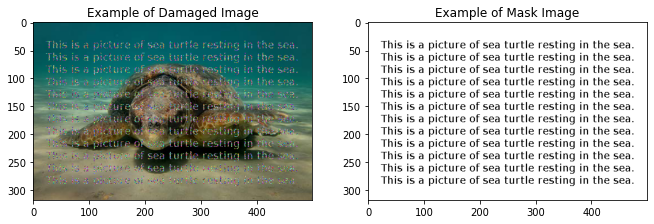

In [14]:
# example image
eximg = imageio.imread('dataimage/transport_input.png').astype(np.uint8) 
exmask = imageio.imread('dataimage/transport_mask.png').astype(np.uint8)

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.imshow(eximg, cmap="gray"); plt.title("Example of Damaged Image") 

plt.subplot(122)
plt.imshow(exmask, cmap="gray"); plt.title("Example of Mask Image")

#**How the HRBF method works in practice**

In this simplified example, we have an image degraded by only one pixel, generated from random values between 0 and 255. In addition, a Boolean mask indicates the position of the pixel that should be restored

In [84]:
row, col = [5, 5]

# matrix 5x5 with values between [0,255]
img = np.random.randint(0,255,(row,col))  
img[int(row/2),int(col/2)] = 0            # center of matrix degraded (zero)
print('Image Degraded \n',img,'\n')

# mask of matrix
mask = np.ones((row,col)).astype(bool)    # Boolean values
mask[int(row/2),int(col/2)] = False
print('Boolean Mask \n',mask)

Image Degraded 
 [[201 162 105 253 106]
 [ 53 244  99  75 207]
 [ 26 191   0 130   0]
 [ 27  64  37 111 152]
 [103 158 194  11  82]] 

Boolean Mask 
 [[ True  True  True  True  True]
 [ True  True  True  True  True]
 [ True  True False  True  True]
 [ True  True  True  True  True]
 [ True  True  True  True  True]]


In the illustration we see the image and its mask respectively

Text(0.5, 1.0, 'Example of Mask Image')

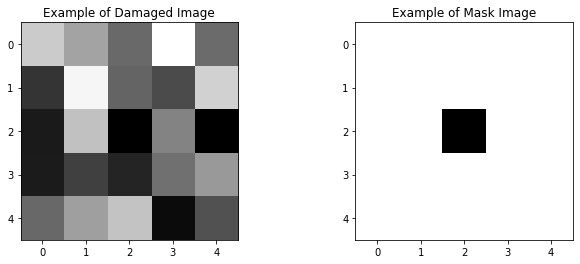

In [85]:
# plotting
plt.figure(figsize=(11,4))
plt.subplot(121)
plt.imshow(img.astype(np.uint8), cmap="gray"); plt.title("Example of Damaged Image") 

plt.subplot(122)
plt.imshow(mask, cmap="gray"); plt.title("Example of Mask Image")

Applying the HRBF method to this case, we have

In [86]:
# RBFHermite 2D
# Script that performs first-order 2D RBF Hermite interpolation

# Define RBF and its derivatives
kernel = {'rbf':    lambda e, r:         np.sqrt(1 + (e * r)**2),
          'dxrbf':  lambda e, r, dx:     dx * e**2 / np.sqrt(1 + (e * r)**2),
          'dyrbf':  lambda e, r, dy:     dy * e**2 / np.sqrt(1 + (e * r)**2),
          'dxxrbf': lambda e, r, dx:     e**2 * (1 + (e * r)**2 - (e * dx)**2) / (1 + (e * r)**2)**(3/2),
          'dyyrbf': lambda e, r, dy:     e**2 * (1 + (e * r)**2 - (e * dy)**2) / (1 + (e * r)**2)**(3/2),
          'dxyrbf': lambda e, r, dx, dy: -e**4 * dx * dy / (1 + (e * r)**2)**(3/2),
          'ep': 6}

idx = grid(mask)                         # grid of image
dsites = idx[mask]                       # position of good pixels region
epoints = idx[~mask]                     # position of degraded region of the image

k = 4                                    # number of neighbors
for i in range(epoints.shape[0]):

  _, neighbors = knn(dsites, epoints[i,:],k)
  mask_knn, mask_target = itermask(mask, neighbors, epoints[i,:])

  gpixels = idx[mask_knn]                # position of good pixels region
  targetpixel = idx[mask_target]         # position of degraded region of the image
  
  rhs = rhs_function(img, mask_knn,_,2)  # intensity values and their derivatives

  # HRBF2D Local Interpolation
  result_image = HRBF2D(gpixels, targetpixel, rhs, kernel)

  # Update image
  img[mask_target] = result_image

The calculation of the method is done on the $k$ nearest neighbors, with $k = 4$ the 4-neighbors (*cyan color*) around the target pixel (*red color*) was generated, and from this neighborhood the substitution operation on the target is done.

Text(0.5, 1.0, 'Restored Image')

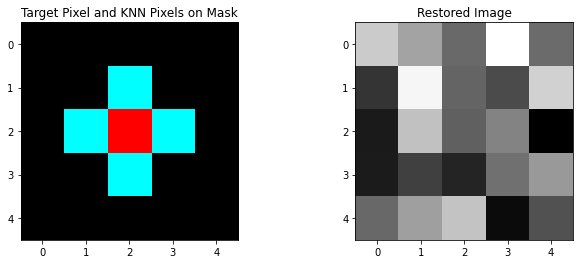

In [87]:
# Mask of target pixel (red color)
masktarget = np.zeros((row,col,3))
masktarget[:,:,0] = 255*mask_target.astype(int)

# Mask of knn pixels (cyan color)
maskknn = np.zeros((row,col,3))
maskknn[:,:,1] = 255*mask_knn.astype(int)
maskknn[:,:,2] = 255*mask_knn.astype(int)

## plotting
plt.figure(figsize=(11,4))
plt.subplot(121)
plt.imshow((masktarget+maskknn).astype(np.uint8), cmap="gray"); plt.title("Target Pixel and KNN Pixels on Mask")

plt.subplot(122)
plt.imshow(img.astype(np.uint8), cmap="gray"); plt.title("Restored Image")

Note: The HRBF in its origin is a global method, i.e. we can use the whole dataset *(good pixels)* to calculate the interpolating function.

#**Partial Report - Tests**

In the initial testing phase, we will look at images with abrupt and smooth changes of intensities, revealing in which situations the HRBF method fits. In addition, the initial tests will serve as a guide for improvements in the results for the final reporting. 

At this point I still have some doubts about how to calculate the gradient for color images in this way, for this reason we will only work with grayscale images.

##**Test 1 - Synthetic Image**

In [34]:
originalimg = imageio.imread('dataimage/cahn_hilliard_clean.png').astype(np.uint8)   # uint8 elements
degradedimg = imageio.imread('dataimage/cahn_hilliard_input.png').astype(np.uint8)   # uint8 elements
mask = imageio.imread('dataimage/cahn_hilliard_mask.png').astype(bool)               # logical elements
# Pattern the Mask
mask = checkmask(mask)

Text(0.5, 1.0, 'Mask of Damaged Image')

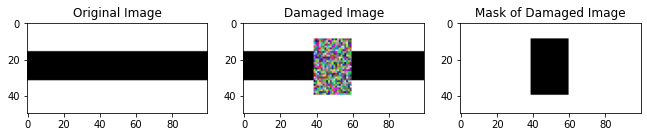

In [35]:
## plotting
plt.figure(figsize=(11,4))
plt.subplot(131)
plt.imshow(originalimg, cmap="gray"); plt.title("Original Image")

plt.subplot(132)
plt.imshow(degradedimg, cmap="gray"); plt.title("Damaged Image") 

plt.subplot(133)
plt.imshow(mask, cmap="gray"); plt.title("Mask of Damaged Image")

Conversion to grayscales,

Text(0.5, 1.0, 'Damaged Image')

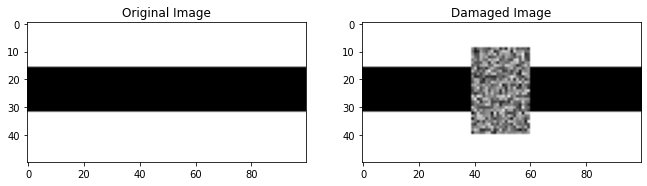

In [36]:
originalimg = rgb2gray(originalimg)
degradedimg = rgb2gray(degradedimg)

## plotting
plt.figure(figsize=(11,4))
plt.subplot(121)
plt.imshow(originalimg, cmap="gray"); plt.title("Original Image")

plt.subplot(122)
plt.imshow(degradedimg, cmap="gray"); plt.title("Damaged Image") 

Applying the HRBF method,

In [ ]:
# RBFHermite 2D
# Script that performs first-order 2D RBF Hermite interpolation

# Define RBF and its derivatives
kernel = {'rbf':    lambda e, r:         np.sqrt(1 + (e * r)**2),
          'dxrbf':  lambda e, r, dx:     dx * e**2 / np.sqrt(1 + (e * r)**2),
          'dyrbf':  lambda e, r, dy:     dy * e**2 / np.sqrt(1 + (e * r)**2),
          'dxxrbf': lambda e, r, dx:     e**2 * (1 + (e * r)**2 - (e * dx)**2) / (1 + (e * r)**2)**(3/2),
          'dyyrbf': lambda e, r, dy:     e**2 * (1 + (e * r)**2 - (e * dy)**2) / (1 + (e * r)**2)**(3/2),
          'dxyrbf': lambda e, r, dx, dy: -e**4 * dx * dy / (1 + (e * r)**2)**(3/2),
          'ep': 6}

idx = grid1(mask)                                       # grid of image
dsites = idx[mask]                                      # position of good pixels region
epoints = idx[~mask]                                    # position of degraded region of the image
rhs = rhs_function(degradedimg, mask,_,2)               # intensity values and their derivatives

# HRBF2D Interpolation
result_image = HRBF2D(dsites, epoints, rhs, kernel)

# Update image
degradedimg[~mask] = result_image

During the inpainting process of the HRBF method it is seen that the memory RAM consumption and the computational time are very high, this is exclusively due to the calculation of the hermite interpolation, which is done on all good pixels (the number of good pixels in the image below) of the image, that is, the calculation is done globally. However, we can concentrate the interpolation calculation only on the good pixels near the degraded region and generate an interpolating function for each degraded pixel, since they are the ones that will interfere with the interpolation function.

In [ ]:
print('good pixels of the image', degradedimg[mask].shape[0])

good pixels of the image 4349


In the resulting image you can see that near the edges the expected result was not obtained. Probably:

- This happened because the image has an abrupt change in intensity, so, as we are using an interpolation process, the image ends up being smoothed and, the edge regions end up suffering this impact.

Text(0.5, 1.0, 'Result Image')

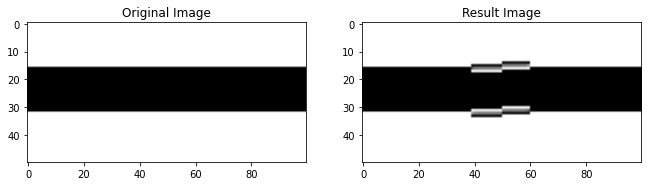

In [ ]:
## plotting
plt.figure(figsize=(11,4))
plt.subplot(121)
plt.imshow(originalimg, cmap="gray"); plt.title("Original Image")

plt.subplot(122)
plt.imshow(degradedimg, cmap="gray"); plt.title("Result Image")

**Possible solutions** to the problem of inpainting on textured images:

- Use techniques seen in class, such as Local Binary Patterns (LBP).

- Inpainting in order of priority  [(Wang et al)](https://www.sciencedirect.com/science/article/abs/pii/S0925231213006334).

**ps:** I accept other suggestions for this correction.

##**Test 2 - Smooth Images**

For this second test, we reserve smooth images.

In [64]:
originalimg = imageio.imread('dataimage/walk.png').astype(np.uint8)     # uint8 elements
degradedimg = imageio.imread('dataimage/walk1.png').astype(np.uint8)    # uint8 elements
mask = imageio.imread('dataimage/walk2.png').astype(bool)               # logical elements
# Pattern the Mask
mask = checkmask(mask)

Text(0.5, 1.0, 'Mask of Damaged Image')

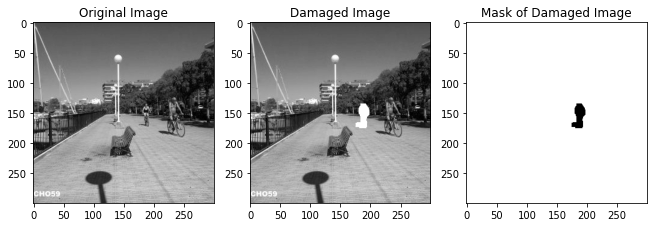

In [65]:
originalimg = rgb2gray(originalimg)
degradedimg = rgb2gray(degradedimg)

## plotting
plt.figure(figsize=(11,4))
plt.subplot(131)
plt.imshow(originalimg, cmap="gray"); plt.title("Original Image")

plt.subplot(132)
plt.imshow(degradedimg, cmap="gray"); plt.title("Damaged Image") 

plt.subplot(133)
plt.imshow(mask, cmap="gray"); plt.title("Mask of Damaged Image")

In the removal process we will simulate a smaller region of the original image such that it preserves all the degraded region of the image in order to select a smaller set of good pixels for generating the interpolating function.

Note that the selection of the good pixels that would be used was done manually, but for a next step we thought about using a morphological process. Erosion/Dilation in the mask to determine a region close to the edge and then apply the difference to the original mask so that only one region remains at the edge of the mask that will be used to determine the interpolating function, improving the computational cost.

Text(0.5, 1.0, 'Small Size Mask')

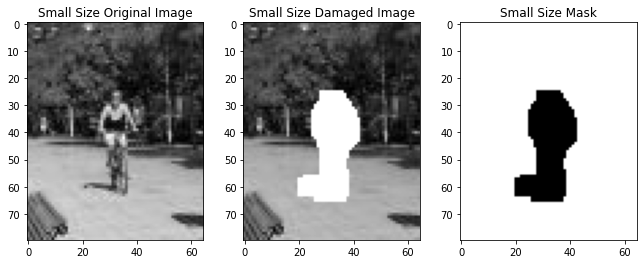

In [66]:
# Image Slices
originalimgsize = originalimg[110:190, 155:220]
degradedimgsize = degradedimg[110:190, 155:220]
masksize = mask[110:190, 155:220]

## plotting
plt.figure(figsize=(11,4))
plt.subplot(131)
plt.imshow(originalimgsize, cmap="gray"); plt.title("Small Size Original Image")

plt.subplot(132)
plt.imshow(degradedimgsize, cmap="gray"); plt.title("Small Size of Damaged Image") 

plt.subplot(133)
plt.imshow(masksize, cmap="gray"); plt.title("Small Size Mask of Damaged Image")

Applying the HRBF method,

In [62]:
# RBFHermite 2D
# Script that performs first-order 2D RBF Hermite interpolation

# Define RBF and its derivatives
kernel = {'rbf':    lambda e, r:         np.sqrt(1 + (e * r)**2),
          'dxrbf':  lambda e, r, dx:     dx * e**2 / np.sqrt(1 + (e * r)**2),
          'dyrbf':  lambda e, r, dy:     dy * e**2 / np.sqrt(1 + (e * r)**2),
          'dxxrbf': lambda e, r, dx:     e**2 * (1 + (e * r)**2 - (e * dx)**2) / (1 + (e * r)**2)**(3/2),
          'dyyrbf': lambda e, r, dy:     e**2 * (1 + (e * r)**2 - (e * dy)**2) / (1 + (e * r)**2)**(3/2),
          'dxyrbf': lambda e, r, dx, dy: -e**4 * dx * dy / (1 + (e * r)**2)**(3/2),
          'ep': 6}

idx = grid1(masksize)                                       # grid of image
dsites = idx[masksize]                                      # position of good pixels region
epoints = idx[~masksize]                                    # position of degraded region of the image
rhs = rhs_function(degradedimgsize, masksize,_,2)           # intensity values and their derivatives

# HRBF2D Interpolation
result_image = HRBF2D(dsites, epoints, rhs, kernel)

# Update image
degradedimgsize[~masksize] = result_image

process result,

Text(0.5, 1.0, 'Result Image')

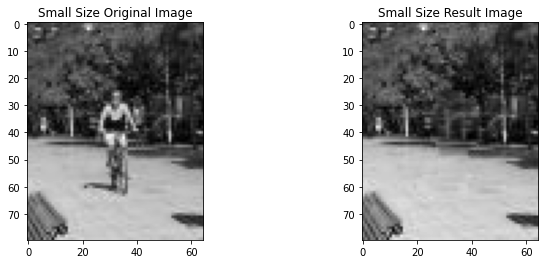

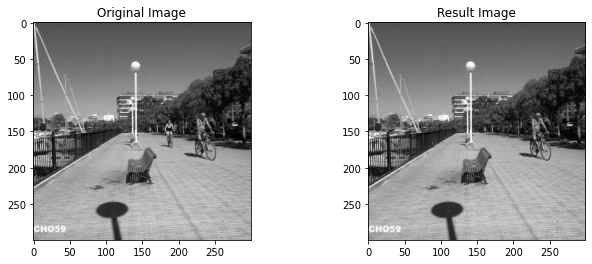

In [63]:
## plotting
plt.figure(figsize=(11,4))
plt.subplot(121)
plt.imshow(originalimgsize, cmap="gray"); plt.title("Small Size Original Image")

plt.subplot(122)
plt.imshow(degradedimgsize, cmap="gray"); plt.title("Small Size Result Image")

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.imshow(originalimg, cmap="gray"); plt.title("Original Image")

plt.subplot(122)
plt.imshow(degradedimg, cmap="gray"); plt.title("Result Image")

Note that for soft images the HRBF method became effective as expected, completely removing the object from the image leaving it looking natural.

#**Questions of Partial Report**

##**Questions**

This space was reserved for some questions to be answered through the project orientation and by me during the research.

- How can I calculate the gradient of a color image ?

- Is a mask dilation process a good option to determine the good pixel region near the edge of the degraded region to generate the interpolating function?

- For now the HRBF method paints all pixels of the image by a single interpolating function, so it does not use the restored pixels in the function calculation. Perhaps using these restored pixels and generating a new function with each iterative process could improve the results?

##**Next Steps**

RBG process:

- Implement the rbg version of the method.

Improve the computational cost:

- Put a process to generate the hermite interpolator function only near the degraded region of the image.

- Generate an interpolating function for each degraded pixel, thus making a local calculation.

Textured Images:

- Maybe an implementation for textured images or a calculation of the degraded pixels by priority.

#**Final Report**

#**HRBF method for RGB images**

The first proposal for improving the research would be to introduce a variation of the HRBF method for color images. Thus, a viable option was to make the calculation by layers.

For example, in an image in RGB format we have three channels, the red (R), green (G) and blue (B) layer. Below is an illustration of the respective layers.

Text(0.5, 1.0, 'Blue Channel')

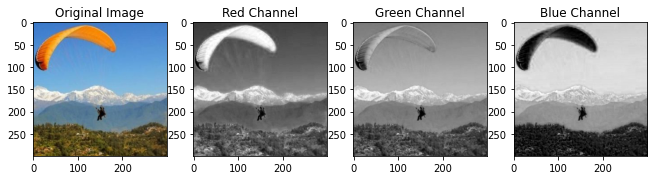

In [13]:
originalimg = imageio.imread('dataimage/air.png').astype(np.uint8)    # uint8 elements

## plotting
plt.figure(figsize=(11,4))
plt.subplot(141)
plt.imshow(originalimg, cmap="gray"); plt.title("Original Image")

plt.subplot(142)
plt.imshow(originalimg[:,:,0], cmap="gray"); plt.title("Red Channel")

plt.subplot(143)
plt.imshow(originalimg[:,:,1], cmap="gray"); plt.title("Green Channel") 

plt.subplot(144)
plt.imshow(originalimg[:,:,2], cmap="gray"); plt.title("Blue Channel")

Another concern for color images in the HRBF method was how to calculate the gradient of these images. In the next example two approaches were tested, first using the gradient directly calculated on a grayscale image originating from the original image and, another way was to calculate the gradient per channel, it does not seem to make much sense, as each channel preserves high intensities of the colors closest to its primary color.

Ex: The red channel has high intensities in the parachute, because its color is the closest to red. This happens for all channels.

##**Test 3 - Synthetic Image**

In this test we use a synthetic image in RGB format.

In [39]:
originalimg = imageio.imread('dataimage/p3.png').astype(np.uint8)     # uint8 elements
img = imageio.imread('dataimage/p.png').astype(np.uint8)              # uint8 elements
degradedimg = img[:,:,0:3]
mask = imageio.imread('dataimage/p2.png').astype(bool)                # logical elements
# Pattern the Mask
mask = checkmask(mask)

Text(0.5, 1.0, 'Mask of Damaged Image')

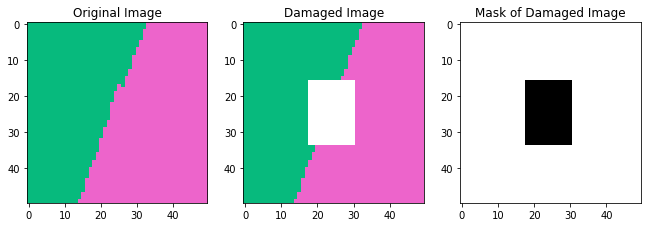

In [40]:
## plotting
plt.figure(figsize=(11,4))
plt.subplot(131)
plt.imshow(originalimg, cmap="gray"); plt.title("Original Image")

plt.subplot(132)
plt.imshow(degradedimg, cmap="gray"); plt.title("Damaged Image") 

plt.subplot(133)
plt.imshow(mask, cmap="gray"); plt.title("Mask of Damaged Image")

In this function we use a grayscale image for the gradient calculation. This image was generated from the original image, in order to compare the result with the gradient calculated by layers.

In [96]:
# Gradient calculation from a grayscale image.
def rhs_graychannel(img, mask,i,F):
  # calculates the partial derivatives with respect to x and y (finite differences) of the good pixels 
  # and arranges into a vector, whose order is the value of the intensities, the partial derivatives 
  # with respect to x and the partial derivatives with respect to y respectively.

  # Single Color Channel (SCC)
  if (F == 2):
    gx, gy = np.gradient(img)                            # gradient calculation
    rhs = np.array([*img[mask], *gx[mask], *gy[mask]])   # rhs of scc image

  # RGB
  if (F == 3):
    grayimage = rgb2gray(img)
    gx, gy = np.gradient(grayimage)                       # gradient calculation          
    rhs = np.array([*img[mask,i], *gx[mask], *gy[mask]])  # rhs of scc image
  
  return (rhs)

In [50]:
# RBFHermite 2D
# Script that performs first-order 2D RBF Hermite interpolation

# Define RBF and its derivatives
kernel = {'rbf':    lambda e, r:         np.sqrt(1 + (e * r)**2),
          'dxrbf':  lambda e, r, dx:     dx * e**2 / np.sqrt(1 + (e * r)**2),
          'dyrbf':  lambda e, r, dy:     dy * e**2 / np.sqrt(1 + (e * r)**2),
          'dxxrbf': lambda e, r, dx:     e**2 * (1 + (e * r)**2 - (e * dx)**2) / (1 + (e * r)**2)**(3/2),
          'dyyrbf': lambda e, r, dy:     e**2 * (1 + (e * r)**2 - (e * dy)**2) / (1 + (e * r)**2)**(3/2),
          'dxyrbf': lambda e, r, dx, dy: -e**4 * dx * dy / (1 + (e * r)**2)**(3/2),
          'ep': 6}

idx = grid1(mask)                                    # grid of image
dsites = idx[mask]                                   # position of good pixels region
epoints = idx[~mask]                                 # position of degraded region of the image

imgraygradient = np.array(degradedimg, copy=True).astype(float)

for i in range(imgraygradient.shape[2]):
  rhs = rhs_graychannel(imgraygradient, mask, i, 3)  # intensity values and their derivatives

  # HRBF2D Interpolation
  result_image = HRBF2D(dsites, epoints, rhs, kernel)

  # Update image
  imgraygradient[~mask,i] = result_image

In [51]:
# RBFHermite 2D
# Script that performs first-order 2D RBF Hermite interpolation

# Define RBF and its derivatives
kernel = {'rbf':    lambda e, r:         np.sqrt(1 + (e * r)**2),
          'dxrbf':  lambda e, r, dx:     dx * e**2 / np.sqrt(1 + (e * r)**2),
          'dyrbf':  lambda e, r, dy:     dy * e**2 / np.sqrt(1 + (e * r)**2),
          'dxxrbf': lambda e, r, dx:     e**2 * (1 + (e * r)**2 - (e * dx)**2) / (1 + (e * r)**2)**(3/2),
          'dyyrbf': lambda e, r, dy:     e**2 * (1 + (e * r)**2 - (e * dy)**2) / (1 + (e * r)**2)**(3/2),
          'dxyrbf': lambda e, r, dx, dy: -e**4 * dx * dy / (1 + (e * r)**2)**(3/2),
          'ep': 6}

idx = grid1(mask)                                    # grid of image
dsites = idx[mask]                                   # position of good pixels region
epoints = idx[~mask]                                 # position of degraded region of the image

for i in range(degradedimg.shape[2]):
  rhs = rhs_function(degradedimg, mask, i, 3)        # intensity values and their derivatives

  # HRBF2D Interpolation
  result_image = HRBF2D(dsites, epoints, rhs, kernel)

  # Update image
  degradedimg[~mask,i] = result_image

Text(0.5, 1.0, 'Gradient for channel')

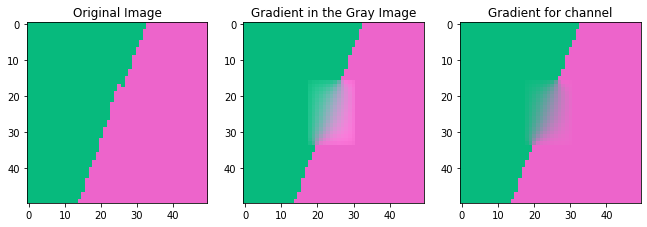

In [52]:
## plotting
plt.figure(figsize=(11,4))
plt.subplot(131)
plt.imshow(originalimg, cmap="gray"); plt.title("Original Image")

plt.subplot(132)
plt.imshow(imgraygradient.astype(np.uint8), cmap="gray"); plt.title("Gradient in the Gray Image")

plt.subplot(133)
plt.imshow(degradedimg.astype(np.uint8), cmap="gray"); plt.title("Gradient for channel")

Note that in neither case was the result excellent, but as discussed earlier, the HRBF method is best used on soft images. However, the image that came closest to the original image was the one using the channel derivatives.

##**Test 4 - Smooth Images**

For the test on color images in RBG format, we have

In [53]:
originalimg = imageio.imread('dataimage/walk.png').astype(np.uint8)     # uint8 elements
degradedimg = imageio.imread('dataimage/walk1.png').astype(np.uint8)    # uint8 elements
mask = imageio.imread('dataimage/walk2.png').astype(bool)               # logical elements
# Pattern the Mask
mask = checkmask(mask)

Text(0.5, 1.0, 'Mask of Damaged Image')

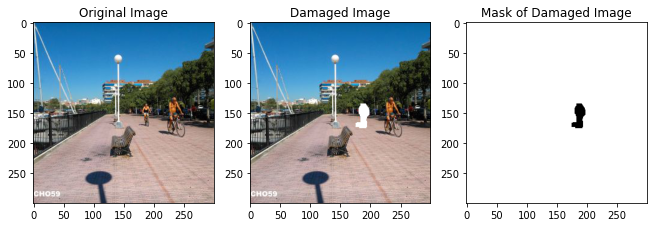

In [54]:
## plotting
plt.figure(figsize=(11,4))
plt.subplot(131)
plt.imshow(originalimg, cmap="gray"); plt.title("Original Image")

plt.subplot(132)
plt.imshow(degradedimg, cmap="gray"); plt.title("Damaged Image") 

plt.subplot(133)
plt.imshow(mask, cmap="gray"); plt.title("Mask of Damaged Image")

Text(0.5, 1.0, 'Small Size Mask of Damaged Image')

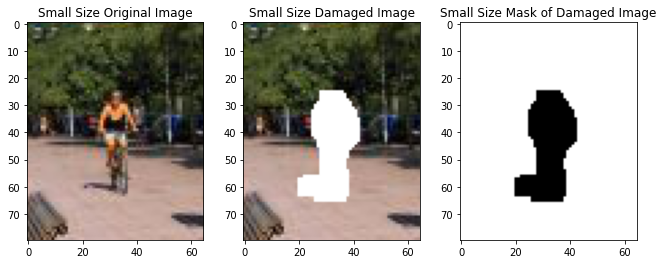

In [55]:
# Image Slices
originalimgsize = originalimg[110:190, 155:220]
degradedimgsize = degradedimg[110:190, 155:220]
masksize = mask[110:190, 155:220]

## plotting
plt.figure(figsize=(11,4))
plt.subplot(131)
plt.imshow(originalimgsize, cmap="gray"); plt.title("Small Size Original Image")

plt.subplot(132)
plt.imshow(degradedimgsize, cmap="gray"); plt.title("Small Size Damaged Image") 

plt.subplot(133)
plt.imshow(masksize, cmap="gray"); plt.title("Small Size Mask of Damaged Image")

In [56]:
# RBFHermite 2D
# Script that performs first-order 2D RBF Hermite interpolation

# Define RBF and its derivatives
kernel = {'rbf':    lambda e, r:         np.sqrt(1 + (e * r)**2),
          'dxrbf':  lambda e, r, dx:     dx * e**2 / np.sqrt(1 + (e * r)**2),
          'dyrbf':  lambda e, r, dy:     dy * e**2 / np.sqrt(1 + (e * r)**2),
          'dxxrbf': lambda e, r, dx:     e**2 * (1 + (e * r)**2 - (e * dx)**2) / (1 + (e * r)**2)**(3/2),
          'dyyrbf': lambda e, r, dy:     e**2 * (1 + (e * r)**2 - (e * dy)**2) / (1 + (e * r)**2)**(3/2),
          'dxyrbf': lambda e, r, dx, dy: -e**4 * dx * dy / (1 + (e * r)**2)**(3/2),
          'ep': 6}

idx = grid1(masksize)                                    # grid of image
dsites = idx[masksize]                                   # position of good pixels region
epoints = idx[~masksize]                                 # position of degraded region of the image

for i in range(degradedimgsize.shape[2]):
  rhs = rhs_function(degradedimgsize, masksize, i, 3)    # intensity values and their derivatives

  # HRBF2D Interpolation
  result_image = HRBF2D(dsites, epoints, rhs, kernel)

  # Update image
  degradedimgsize[~masksize,i] = result_image

Text(0.5, 1.0, 'Result Image')

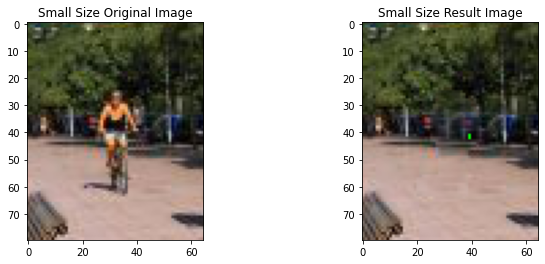

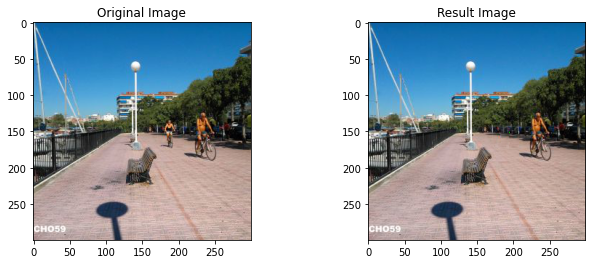

In [58]:
## plotting
plt.figure(figsize=(11,4))
plt.subplot(121)
plt.imshow(originalimgsize, cmap="gray"); plt.title("Small Size Original Image")

plt.subplot(122)
plt.imshow(degradedimgsize, cmap="gray"); plt.title("Small Size Result Image")

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.imshow(originalimg, cmap="gray"); plt.title("Original Image")

plt.subplot(122)
plt.imshow(degradedimg.astype(np.uint8), cmap="gray"); plt.title("Result Image")

Likewise for grayscale soft images, the process for RBG images was satisfactory. The resulting image comprises the characteristics of the original image while retaining its texture.

#**HRBF local methods**

Until now the HRBF method was calculated globally, i.e. all good pixels were used to acquire the interpolating function that restores the degraded pixels. However, the computational cost for this task is absolutely high, so in this section we separate two ideas for an attempt to reduce the computational cost while maintaining the accuracy of the interpolating function.

##**HRBF method with dilatation process**

The first alternative method is the use of a dilation process in the HRBF method.

In [13]:
from skimage import morphology
from skimage.morphology import (square, rectangle, diamond, disk, star)

In [14]:
originalimg = imageio.imread('dataimage/house.png').astype(np.uint8)    # uint8 elements
degradedimg = imageio.imread('dataimage/house1.png').astype(np.uint8)   # uint8 elements
mask = imageio.imread('dataimage/house2.png').astype(bool)              # logical elements
# Pattern the Mask
mask = checkmask(mask)

Text(0.5, 1.0, 'Mask of Damaged Image')

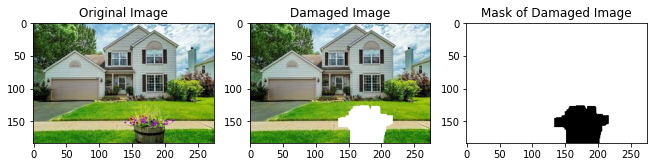

In [15]:
#originalimg = rgb2gray(originalimg)
#degradedimg = rgb2gray(degradedimg)

## plotting
plt.figure(figsize=(11,4))
plt.subplot(131)
plt.imshow(originalimg, cmap="gray"); plt.title("Original Image")

plt.subplot(132)
plt.imshow(degradedimg, cmap="gray"); plt.title("Damaged Image") 

plt.subplot(133)
plt.imshow(mask, cmap="gray"); plt.title("Mask of Damaged Image")

In this process, the dilation effect is applied to the mask that identifies the degraded region, creating a new mask with a larger retouch area.

The intention is to calculate the difference between this new area and the original, generating a "contour" for the mask. This contour is constructed of good pixels that have been selected for the Hermite interpolation calculation, significantly affecting the computational cost of the method.

Text(0.5, 1.0, 'Good pixels (white values)')

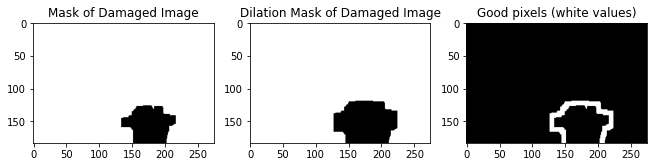

In [83]:
morpho = ~morphology.dilation(~mask, square(15))
maskdilation = ~morpho != mask

## plotting
plt.figure(figsize=(11,4))

plt.subplot(131)
plt.imshow(mask, cmap="gray"); plt.title("Mask of Damaged Image")

plt.subplot(132)
plt.imshow(morpho, cmap="gray"); plt.title("Dilation Mask of Damaged Image")

plt.subplot(133)
plt.imshow(~maskdilation, cmap="gray"); plt.title("Good pixels (white values)")

In [87]:
# RBFHermite 2D
# Script that performs first-order 2D RBF Hermite interpolation

# Define RBF and its derivatives
kernel = {'rbf':    lambda e, r:         np.sqrt(1 + (e * r)**2),
          'dxrbf':  lambda e, r, dx:     dx * e**2 / np.sqrt(1 + (e * r)**2),
          'dyrbf':  lambda e, r, dy:     dy * e**2 / np.sqrt(1 + (e * r)**2),
          'dxxrbf': lambda e, r, dx:     e**2 * (1 + (e * r)**2 - (e * dx)**2) / (1 + (e * r)**2)**(3/2),
          'dyyrbf': lambda e, r, dy:     e**2 * (1 + (e * r)**2 - (e * dy)**2) / (1 + (e * r)**2)**(3/2),
          'dxyrbf': lambda e, r, dx, dy: -e**4 * dx * dy / (1 + (e * r)**2)**(3/2),
          'ep': 6}

idx = grid(maskdilation)                                   # grid of image
dsites = idx[~maskdilation]                                # position of good pixels region
epoints = idx[~mask]                                       # position of degraded region of the image

for i in range(degradedimg.shape[2]):
  rhs = rhs_function(degradedimg, ~maskdilation, i, 3)     # intensity values and their derivatives

  # HRBF2D Local Interpolation
  result_image = HRBF2D(dsites, epoints, rhs, kernel)

  # Update image
  degradedimg[~mask,i] = result_image

Text(0.5, 1.0, 'Result Image')

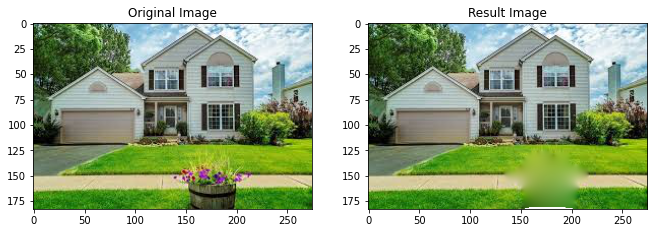

In [88]:
## plotting
plt.figure(figsize=(11,4))
plt.subplot(121)
plt.imshow(originalimg, cmap="gray"); plt.title("Original Image")

plt.subplot(122)
plt.imshow(degradedimg, cmap="gray"); plt.title("Result Image")

Compared to the global version, the calculation made only by points near the degraded region from the dilatation process had significant results in the computational cost. However, the region was not reconstructed correctly, which leads us to believe that more distant pixels are relevant to generate the interpolating function correctly.

##**HRBF method with target pixels**

Another version of the HRBF method for a local shape is done by varying the mesh, i.e., at each iteration of the method, we decide which pixel will be restored (only one) with the respective k closest pixels. Thus, we work with a smaller data set and linear system.

In [87]:
originalimg = imageio.imread('dataimage/zoo.png').astype(np.uint8)   # uint8 elements                                                   # file of input image
degradedimg = imageio.imread('dataimage/zoo1.png').astype(np.uint8)  # uint8 elements                                                 # file of input mask
mask = imageio.imread('dataimage/zoo2.png').astype(bool)             # logical elements
# Pattern the Mask
mask = checkmask(mask)

Text(0.5, 1.0, 'Mask of Damaged Image')

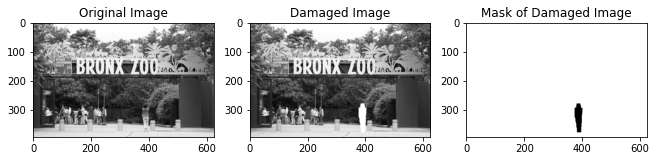

In [88]:
originalimg = rgb2gray(originalimg)
degradedimg = rgb2gray(degradedimg)

## plotting
plt.figure(figsize=(11,4))
plt.subplot(131)
plt.imshow(originalimg, cmap="gray"); plt.title("Original Image")

plt.subplot(132)
plt.imshow(degradedimg, cmap="gray"); plt.title("Damaged Image") 

plt.subplot(133)
plt.imshow(mask, cmap="gray"); plt.title("Mask of Damaged Image") 

Text(0.5, 1.0, 'Zoom Mask of Damaged Image')

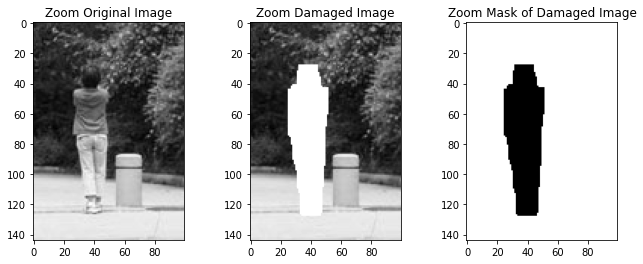

In [89]:
originalimgzoom = originalimg[250:400,350:450]
degradedimgzoom = degradedimg[250:400,350:450]
maskzoom = mask[250:400,350:450]

## plotting
plt.figure(figsize=(11,4))
plt.subplot(131)
plt.imshow(originalimgzoom, cmap="gray"); plt.title("Zoom Original Image")

plt.subplot(132)
plt.imshow(degradedimgzoom, cmap="gray"); plt.title("Zoom Damaged Image") 

plt.subplot(133)
plt.imshow(maskzoom, cmap="gray"); plt.title("Zoom Mask of Damaged Image") 

At target pixel $300$ with $k = 6$ numbers of neighbors,

In [90]:
i = 300                                   # selects the target pixel
k = 10                                    # number of neighboring pixels
idx = grid(mask)                          # grid of image
dsites = idx[mask]                        # position of good pixels region
epoints = idx[~mask]                      # position of degraded region of the image
_, neighbors = knn(dsites, epoints[i,:],k)
mask_knn, mask_target = itermask(mask, neighbors, epoints[i,:])

gpixels = idx[mask_knn]                   # position of good pixels region
targetpixel = idx[mask_target]            # position of degraded region of the image

we generate a reduced data set, being it

In [91]:
print('K = ', k, '\n')
print('Target Pixel = \n', targetpixel, '\n')
print('Knn Pixels = \n', gpixels)

K =  10 

Target Pixel = 
 [[295 392]] 

Knn Pixels = 
 [[289 397]
 [289 398]
 [290 397]
 [290 398]
 [291 397]
 [291 398]
 [291 399]
 [292 398]
 [292 399]
 [292 400]]


we have the selected target pixel (red color) together with its k nearest neighbors (cyan color)

Text(0.5, 1.0, 'Zoom')

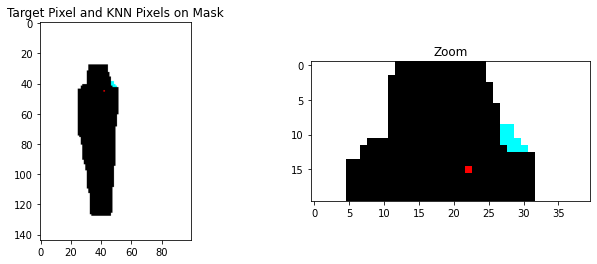

In [92]:
row, col = mask.shape

# Mask of target pixel (red color) and Knn pixel (cyan color)
maskilustrator = np.zeros((row,col,3))
maskilustrator[:,:,0] = mask
maskilustrator[:,:,1] = mask
maskilustrator[:,:,2] = mask
maskilustrator[mask_target,0] = True
maskilustrator[mask_knn,0] = False
maskilustrator[mask_knn,1] = True
maskilustrator[mask_knn,2] = True

maskilustrator = 255*maskilustrator.astype(int)

## plotting
plt.figure(figsize=(11,4))
plt.subplot(121)
plt.imshow((maskilustrator[250:400,350:450,:]).astype(np.uint8), cmap="gray"); plt.title("Target Pixel and KNN Pixels on Mask")

plt.subplot(122)
plt.imshow((maskilustrator[280:300,370:410,:]).astype(np.uint8), cmap="gray"); plt.title("Zoom")

In [ ]:
# RBFHermite 2D
# Script that performs first-order 2D RBF Hermite interpolation

# Define RBF and its derivatives
kernel = {'rbf':    lambda e, r:         np.sqrt(1 + (e * r)**2),
          'dxrbf':  lambda e, r, dx:     dx * e**2 / np.sqrt(1 + (e * r)**2),
          'dyrbf':  lambda e, r, dy:     dy * e**2 / np.sqrt(1 + (e * r)**2),
          'dxxrbf': lambda e, r, dx:     e**2 * (1 + (e * r)**2 - (e * dx)**2) / (1 + (e * r)**2)**(3/2),
          'dyyrbf': lambda e, r, dy:     e**2 * (1 + (e * r)**2 - (e * dy)**2) / (1 + (e * r)**2)**(3/2),
          'dxyrbf': lambda e, r, dx, dy: -e**4 * dx * dy / (1 + (e * r)**2)**(3/2),
          'ep': 7}

idx = grid(maskzoom)                          # grid of image
dsites = idx[maskzoom]                        # position of good pixels region
epoints = idx[~maskzoom]                      # position of degraded region of the image
rhs = rhslocal(degradedimgzoom)               # intensity values and their derivatives

k = 3
for i in range(epoints.shape[0]):

  _, neighbors = knn(dsites, epoints[i,:],k)
  mask_knn, mask_target = itermask(maskzoom, neighbors, epoints[i,:])

  gpixels = idx[mask_knn]                # position of good pixels region
  targetpixel = idx[mask_target]         # position of degraded region of the image
  
  slicerhs = rhs[mask_knn].T.reshape(k*3)
  
  # HRBF2D Local Interpolation
  result_image = HRBF2D(gpixels, targetpixel, slicerhs, kernel)

  # Update image
  degradedimgzoom[mask_target] = result_image

Text(0.5, 1.0, 'Result Image')

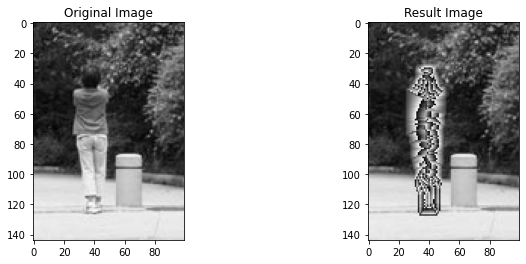

In [95]:
## plotting
plt.figure(figsize=(11,4))
plt.subplot(121)
plt.imshow(originalimgzoom, cmap="gray"); plt.title("Original Image")

plt.subplot(122)
plt.imshow(degradedimgzoom, cmap="gray"); plt.title("Result Image")

The process is repeated in small portions, until the image is completely reconstructed.

Note that, as with the local dilation process, the result was not satisfactory, i.e., using a reduced region even though it is close to the degraded area affects the recognition of important features in image restoration.

#**Conclusion**

Hermite RBF Interpolation Digital Inpainting was a challenging method to put into practice techniques seen during the course of digital image processing.

For this challenge we separated the input images into two categories, textured and smooth. As seen, the HRBF method in its global form had excellent results for smooth images, and left something to be desired in the border regions of the degraded areas, this was already expected, after all the interpolator function is a smoothing function, so to correct this flaw we would need other techniques for textured images. 

As for the performance of the HRBF in its local form, it has not yet been possible to obtain good results, but we believe that there is still a great path to be explored in this direction.

The HRBF is an adaptation of the surface-oriented version. So for digital image processing this is a novel approach. Therefore, believing in the potential of this method we have separated some topics below that will be worked on in the future.

#**Next Steps**

HRBF in its local form:

- Improve the HRBF algorithm in its local form, because the computational cost is indispensable in the calculation of the interpolating function.

- maybe creating a gradient sample of the entire image would be an option.

Use the restored pixels:

- One approach not seen in this project, but which could be of great value is the use of the restored pixels in the iteration process, so the more centralized target pixels of the degraded region could be better supported in their computation.